In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
import seaborn as sns
%matplotlib inline
pathfinal =  r'C:/Users/mjc341/desktop/UMAN 1625 A-B testingBaysean/ABpngs/'

In [2]:
def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
        data = []
        N = N_A + N_B
        group_bern = scs.bernoulli(0.5)
        A_bern = scs.bernoulli(p_A)
        B_bern = scs.bernoulli(p_B)
        for idx in range(N):
        # initite empty row
            row = {}
        # for 'ts' column
            if days is not None:
                if type(days) == int:
                    row['ts'] = idx // (N // days)
                else:
                    raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        # .rvs is random variates of a given size
        # so this will create 1 or 0 yes or no type random variable
            row['group'] = group_bern.rvs()

            if row['group'] == 0:
            # assign conversion based on provided parameters
                row['opened'] = A_bern.rvs()
            else:
                row['opened'] = B_bern.rvs()
        # collect row into data container
            data.append(row)

    # convert data into pandas dataframe
        df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
        df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

        return df
            

In [3]:
N_A = 1000
N_B = 1000
p_A = 0.64
#p_B is the open rate of the test emails, since we do not have a test case we can use dummy value
#here i give the test value a higher open rate  AS IF the test was sucessful
p_B = 0.68

In [4]:
ab_data = generate_data(N_A,N_B,p_A,p_B)

In [5]:
ab_data.head(3)

,group,opened
0,B,1
1,A,1
2,B,1


In [6]:
ab_data.shape

(2000, 2)

In [7]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

In [8]:
A_opened, B_opened = A_group['opened'].sum(), B_group['opened'].sum()
A_opened, B_opened

(647, 685)

In [9]:

A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(994, 1006)

In [10]:
p_A, p_B = A_opened / A_total, B_opened / B_total
round(p_A,2), round(p_B,2)

(0.65, 0.68)

In [11]:
# the difference or the improvement to A as shown by test B is .06
p_B - p_A

0.030009080326891757

In [12]:
ab_summary = ab_data.pivot_table(values='opened', index='group', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = ab_data.pivot_table(values='opened', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='opened', index='group')

In [13]:
ab_summary

,opened,total,rate
group,,,
A,647,994,0.650905
B,685,1006,0.680915


In [14]:
#basically 71% of A
p_B * A_total

676.8290258449304

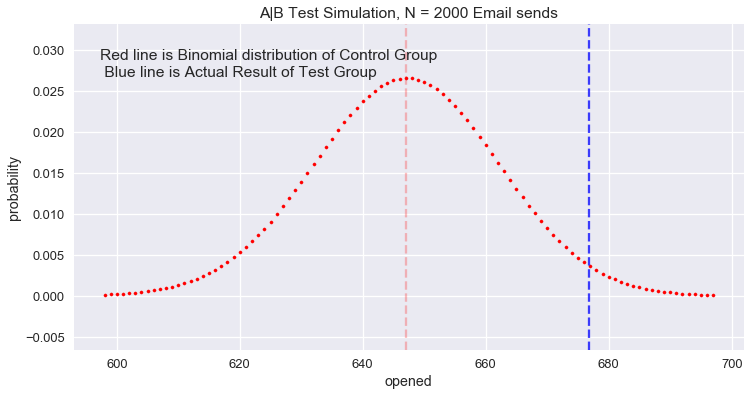

In [15]:
#create a plot that shows the probablity
# .pmf is the probability mass function 
sns.set_style('darkgrid')
sns.set_context ('talk')
color = sns.color_palette('Dark2',6)
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_opened-49, A_opened+50, 100)
# this is the distribution of 100 points using the opened count for A
y = scs.binom(A_total, p_A).pmf(x)
#use the .pmf of the line generated above
ax.scatter(x, y, s=10, c= 'red')
ax.axvline(x=p_A* A_total, c = 'red',alpha = 0.25, linestyle = '--')
ax.axvline(x=p_B * A_total, c='blue', alpha=0.75, linestyle='--') 
#above is the blue vetical line the total of A * total B opened
plt.xlabel('opened')
plt.ylabel('probability')
plt.title('A|B Test Simulation, N = 2000 Email sends')
plt.annotate('Red line is Binomial distribution of Control Group\n Blue line is Actual Result of Test Group',xy = (100,320), xycoords = 'figure points')
plt.savefig(pathfinal + "AB_Simulation1.png")

If we plot the binomial distribution that corresponds to the control group we would get the plot above in red. If we want to evaluate the probability of getting the result from the test group based on the binomial distribution from the control group, we would get the following:

In [16]:
#The red line is the distribution of the results of the control group, what is the probability of  
#getting the test group result using the control group distribution 
#in other words what are the chances that the test group result is random? 
#.pmf is the probaility mass function
scs.binom(A_total, p_A).pmf(728)

7.442940151336909e-09

That is a very low probability. If we are comparing this to a significance level, typically referred to as alpha, we would say that the result is drastically lower than 5% or even 1%. In other words, there was a 0.2% chance that we would have seen this result. Is this enough evidence of statistical significance? Let's get into statistical power.

We can plot the data from both groups as binomial distributions.

Text(0,0.5,'probability')

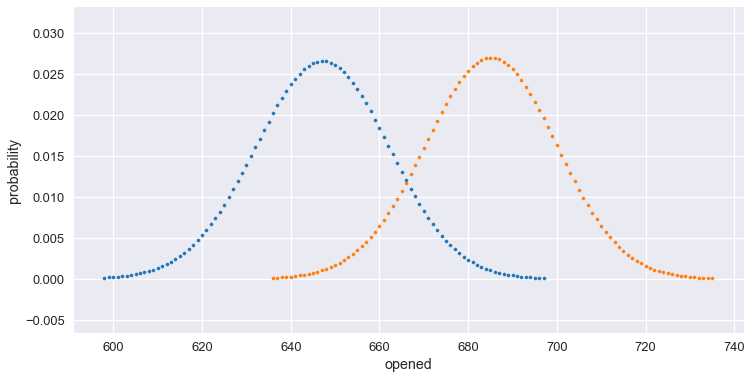

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_opened-49, A_opened+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.scatter(xA, yA, s=10)
xB = np.linspace(B_opened-49, B_opened+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.scatter(xB, yB, s=10)
plt.xlabel('opened')
plt.ylabel('probability')


We can see that the test group converted more users than the control group. However, the plot above is not a plot of the null and alternate hypothesis. The null hypothesis is a plot of the difference between the probability of the two groups.In order to calculate the difference between the two groups, we need to standardize the data. Because the number of samples might be different between the two groups, we should compare the probability of successes, p.

In [18]:
#now we are calculating the difference betwen the probability of the 2 groups but first standardize
#Calculate the probability of sucess for A  SE_A
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_A

0.015119495536718545

In [19]:
#Calculate the probalitiy of the success of B
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)
SE_B

0.014696057105473668

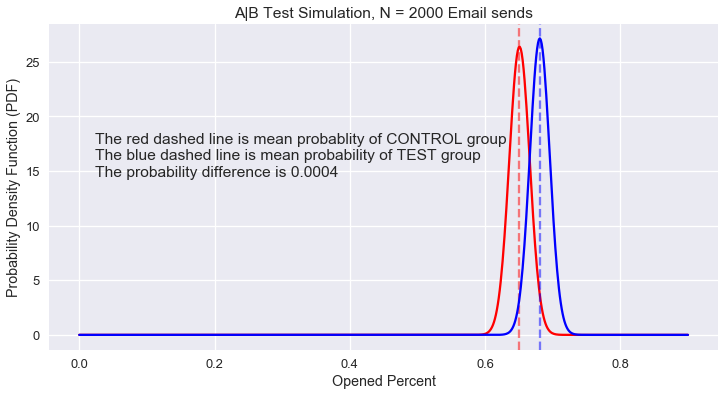

In [20]:
sns.set_style('darkgrid')
sns.set_context ('talk')
color = sns.color_palette('Dark2',6)
fig, ax = plt.subplots(figsize=(12,6))
Dhat = SE_A-SE_B
Dhat = round(Dhat,4)
Dhat=(str(Dhat))
xA = np.linspace(0, .9, 638) #np.linspace return evenly spaced numbers over a specified interval
yA = scs.norm(p_A, SE_A).pdf(xA) # p_A is .64 and SE_A 0.015 generate a normal distribution of 
ax.plot(xA, yA, c = 'red')
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')

xB = np.linspace(0, .9, 671)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB, c = 'blue')
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')

plt.xlabel('Opened Percent')
plt.ylabel('Probability Density Function (PDF)')
plt.title('A|B Test Simulation, N = 2000 Email sends')
plt.annotate('The red dashed line is mean probablity of CONTROL group\nThe blue dashed line is mean probability of TEST group\nThe probability difference is '+ Dhat,xy = (95,220), xycoords = 'figure points')
plt.savefig(pathfinal + "AB_Simulation2.png")


The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to d_hat.

$$ \hat{d} = \hat{p}_B - \hat{p}_A $$

Scince the mean coversion rates have a difference and this distance is NOT 0 then the null hyp is going to be FALSE



Back to the Null and Alternate Hypothesis
Recall that the null hypothesis states that the difference in probability between the two groups is zero. We should construct a distribution of this difference, since for any A/B experiment our value for p each come from a two different distributions and the difference will have its own variance.

$$ H_0: d = 0 $$$$ \hat{d} \sim Normal(0, \: SE_{pool}) $$
$$ H_A: d = p_B - p_A $$$$ \hat{d} \sim Normal(d, \: SE_{pool}) $$
Variance of the Sum

The variance of the sum (of two random independent variables) is the sum of the variances.

$$ Var(X + Y) = Var(X) + Var(Y) $$$$ Var(X - Y) = Var(X) + Var(Y) $$
Because the distribution for the difference is calculated from two normal distributions, we can assume that the difference will be normally distributed.

The null hypothesis is the normal distribution of the difference with a mean of zero.

The alternate hypothesis is the normal distribution of the difference with a mean of the difference in the means of the two groups.

The null hypothesis and alternate hypothesis will the same variance which will be the sum of the variances for the control group and the test group.

$$ Var(\hat{d}) = Var(\hat{p}_B - \hat{p}_A) = Var(\hat{p}_A) + Var(\hat{p}_B) = \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} $$
The standard deviation will be the square root of the variance.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} } $$
Pooled Variance
We can put this equation in terms of $s$, where $s$ is the standard deviation of the Bernoulli distribution.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_A^2}{n_A} + \frac{s_B^2}{n_B} } $$